![header](../images/header.jpg)

# Predicting Condition of Tanzanian Water Wells

**Author:** [Jonathan Fetterolf](mailto:jonathan.fetterolf@gmail.com)

## Overview

## Business Understanding and Business Problem
IHH Humanitarian Relief Foundation is an NGO that provides and maintains water wells in areas where clean water is inaccessible. Building an accurate classification model to predict whether a pump is functional, or in need of repairs will help to streamline their operations. These predictions will maximize their maintenance operations and will ensure clean and potable water is available to the people of Tanzania. 

### Cost of Errors
Tanzania has an area of 364,900 mi² which makes it the 30th largest country in the world. According to [trade.gov](https://www.trade.gov/country-commercial-guides/tanzania-construction), the managed national road network consists of 21058 miles of roadway, comprising 7944 miles of trunk and 13114 miles of regional roads. Due to the size of the country, the condition of infrastructure, and a limited budget of both capital and manpower, it is important to only deploy maintenance and repair efforts to the locations that are positively in need of repair. 

Constructing a well in Tanzania can cost upwards of $10000 ([The Living Water Project](https://www.livingwaterwells.org/faqs)) depending on factors such as:
- cost of goods and labor
- necessary drilling depth
- amount of rock to drill through
- location of well
- cost of fuel (drilling and transportation)

Pumps in wells generally last 10 or more years but their parts do have a finite life span. The cost of repairing a well can range from a few hundred dollars to several thousand dollars. Sending repair efforts to wells that are predicted to need repairs but are in fact functioning (a false positive) use costly resources that could be put toward the wells that are actually in need of repair. 

## Data Understanding
Data for this project is from [Taarifa](http://taarifa.org/) and the [Tanzanian Ministry of Water](http://maji.go.tz/).

### Imports

In [84]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, log_loss, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

## Import Initial Data

In [2]:
df = pd.read_csv('../data/training_set_values.csv', index_col='id')

## Functions/Classes

In [3]:
def null_info(col_name, df_name=df):
    '''
    give this function a column name and name of the DataFrame to
    receive a printout with how many null values the column contains,
    the percentage of missing values in that column, the top 5 values
    of the column, and how many unique values are in the column. 
    '''
    percent = round((df_name[col_name].isna().sum() / df_length) * 100, ndigits=2)
    values = df_name[col_name].value_counts().head()
    num_unique = len(list(df_name[col_name].unique()))
    col_type = df_name[col_name].dtypes
    total_nulls = df_name[col_name].isna().sum()
    return print(f'''Column Name: '{col_name}'\n
This column consists of {col_type}s and has {total_nulls} null values.\n
The percentage of missing values in the {col_name} \
column is {percent}%.\n
The top values in {col_name} are:\n
{values}\n
There are {num_unique} unique values in this column.
    ''')

In [4]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )
        return ax

## Pipelines & Transformers

In [5]:
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss',StandardScaler())
])

In [6]:
cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [7]:
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
],remainder='passthrough')

## Custom Colors

In [8]:
#yellow: #FDD116, blue: #00A3DE, green: #1FB53A, black: #000000
gn_bu = ['#1FB53A', '#00A3DE']
gn_bu_pal = sns.color_palette(gn_bu)

bu_yl = ['#00A3DE', '#FDD116']
bu_yl_pal = sns.color_palette(bu_yl)

gn = ['#1FB53A']
gn_pal = sns.color_palette(gn)

gn_yl_bu = ['#1FB53A', '#FDD116', '#00A3DE']
gn_yl_bu_pal = sns.color_palette(gn_yl_bu)

yl_bu_gn = ['#FDD116', '#00A3DE', '#1FB53A']
yl_bu_gn_pal = sns.color_palette(yl_bu_gn)

## Data Understanding

In [9]:
df_length = len(df)
df_length

59400

In [10]:
col_names = list(df.columns)
num_cols = len(col_names)

print(f'The column names are: {col_names}\nNumber of columns: {num_cols}')

The column names are: ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
Number of columns: 39


### About the columns:
amount_tsh - Total static head (amount water available to waterpoint)<br>
date_recorded - The date the row was entered<br>
funder - Who funded the well<br>
gps_height - Altitude of the well<br>
installer - Organization that installed the well<br>
longitude - GPS coordinate<br>
latitude - GPS coordinate<br>
wpt_name - Name of the waterpoint if there is one<br>
num_private - <br>
basin - Geographic water basin<br>
subvillage - Geographic location<br>
region - Geographic location<br>
region_code - Geographic location (coded)<br>
district_code - Geographic location (coded)<br>
lga - Geographic location<br>
ward - Geographic location<br>
population - Population around the well<br>
public_meeting - True/False<br>
recorded_by - Group entering this row of data<br>
scheme_management - Who operates the waterpoint<br>
scheme_name - Who operates the waterpoint<br>
permit - If the waterpoint is permitted<br>
construction_year - Year the waterpoint was constructed<br>
extraction_type - The kind of extraction the waterpoint uses<br>
extraction_type_group - The kind of extraction the waterpoint uses<br>
extraction_type_class - The kind of extraction the waterpoint uses<br>
management - How the waterpoint is managed<br>
management_group - How the waterpoint is managed<br>
payment - What the water costs<br>
payment_type - What the water costs<br>
water_quality - The quality of the water<br>
quality_group - The quality of the water<br>
quantity - The quantity of water<br>
quantity_group - The quantity of water<br>
source - The source of the water<br>
source_type - The source of the water<br>
source_class - The source of the water<br>
waterpoint_type - The kind of waterpoint<br>
waterpoint_type_group - The kind of waterpoint<br>

In [11]:
# let's see what we're working with
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Joining Original DataFrame with Target

The condition labels are in a separate DataFrame so we need to bring them in.

In [12]:
df_target = pd.read_csv('../data/training_set_labels.csv', index_col='id')

In [13]:
df_target.columns

Index(['status_group'], dtype='object')

In [14]:
df_target.info(),
df_target.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  59400 non-null  object
dtypes: object(1)
memory usage: 928.1+ KB


,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [15]:
# looks like we have the same number of rows.
df_target.shape, df.shape

((59400, 1), (59400, 39))

In [16]:
df = df.join(df_target)

In [17]:
# okay, our data is consolidated
df.shape

(59400, 40)

In [18]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


What are we looking at?

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [20]:
df.index.value_counts().sum()

59400

The index column, 'id' is a unique identifier for each row in the DataFrame

In [21]:
df.wpt_name.value_counts()

none                     3563
Shuleni                  1748
Zahanati                  830
Msikitini                 535
Kanisani                  323
                         ... 
Kwa Donasian Assenga        1
Kwa Joseph Mwakakusyu       1
Yusuph Kubala               1
Kwa Mzee Yose               1
Mazimwana                   1
Name: wpt_name, Length: 37400, dtype: int64

The 'wpt_name' column is interesting because most waterpoints have names and some of those names are repeated and show up frequently.

In [22]:
df.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [23]:
percent_of_zeroes = round(100 * (df.num_private.value_counts()[0]/len(df.num_private)))

print(f'Zero is the most common value in "num_private" and it makes up approximately {percent_of_zeroes}% of entries.')

Zero is the most common value in "num_private" and it makes up approximately 99.0% of entries.


All of the following columns describe the geographic location: 
'longitude', 'latitude', 'basin', 'subvillage', 'region', 'region_code', 'distric_code', 'lga', 'ward'

In [24]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


I need to look into the 'construction_year' column because it has a minimum year of '0'.

In [25]:
year_zero_percent = round(100 * df.construction_year.value_counts(ascending=False)\
      [0]/len(df.construction_year), ndigits=2)
print(f'{year_zero_percent}% of the values in the column are zero')

34.86% of the values in the column are zero


I will have to remove all values of zero, filling them as null values and decide how to proceed when dealing with other null values.

In [26]:
df['construction_year'] = df['construction_year'].replace({0:np.NaN})

In [27]:
df.construction_year.head()

id
69572    1999.0
8776     2010.0
34310    2009.0
67743    1986.0
19728       NaN
Name: construction_year, dtype: float64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

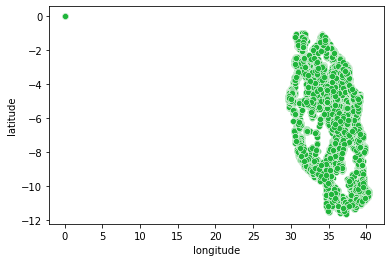

In [28]:
fig0, ax0 = plt.subplots()

sns.scatterplot(data=df, x='longitude', y='latitude', color='#1FB53A', ax=ax0)

The latitudinal and longitudinal values do not make sense for this value, we'll have to convert to NaN and let the numeric imputer handle it.

In [29]:
#changing longitudinal values < 20 to np.NaN
df['longitude'].mask(df['longitude'] < 20 , np.NaN, inplace=True)
#changing latitudinal values > .5 to np.NaN
df['latitude'].mask(df['latitude'] > .5 , np.NaN, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

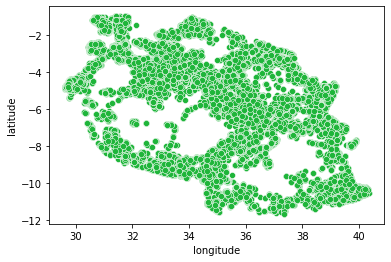

In [30]:
fig1, ax1 = plt.subplots()

sns.scatterplot(data=df, x='longitude', y='latitude', color='#1FB53A', ax=ax1)

### Addressing Null Values

In [31]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                 1812
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year        20709
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

#### 'funder'

In [32]:
null_info('funder')

Column Name: 'funder'

This column consists of objects and has 3635 null values.

The percentage of missing values in the funder column is 6.12%.

The top values in funder are:

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Name: funder, dtype: int64

There are 1898 unique values in this column.
    


#### 'installer'

In [33]:
null_info('installer')

Column Name: 'installer'

This column consists of objects and has 3655 null values.

The percentage of missing values in the installer column is 6.15%.

The top values in installer are:

DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: installer, dtype: int64

There are 2146 unique values in this column.
    


#### 'subvillage'

In [34]:
null_info('subvillage')

Column Name: 'subvillage'

This column consists of objects and has 371 null values.

The percentage of missing values in the subvillage column is 0.62%.

The top values in subvillage are:

Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
Name: subvillage, dtype: int64

There are 19288 unique values in this column.
    


#### 'public_meeting'

In [35]:
null_info('public_meeting')

Column Name: 'public_meeting'

This column consists of objects and has 3334 null values.

The percentage of missing values in the public_meeting column is 5.61%.

The top values in public_meeting are:

True     51011
False     5055
Name: public_meeting, dtype: int64

There are 3 unique values in this column.
    


#### 'scheme_management'

In [36]:
null_info('scheme_management')

Column Name: 'scheme_management'

This column consists of objects and has 3877 null values.

The percentage of missing values in the scheme_management column is 6.53%.

The top values in scheme_management are:

VWC                36793
WUG                 5206
Water authority     3153
WUA                 2883
Water Board         2748
Name: scheme_management, dtype: int64

There are 13 unique values in this column.
    


#### 'scheme_name'

In [37]:
null_info('scheme_name')

Column Name: 'scheme_name'

This column consists of objects and has 28166 null values.

The percentage of missing values in the scheme_name column is 47.42%.

The top values in scheme_name are:

K                682
None             644
Borehole         546
Chalinze wate    405
M                400
Name: scheme_name, dtype: int64

There are 2697 unique values in this column.
    


I will drop this column because over 47% of the rows have missing data and the 'scheme_managment' column has the same description of, "Who operates the waterpoint."

#### 'construction_year'

In [38]:
null_info('construction_year', df)

Column Name: 'construction_year'

This column consists of float64s and has 20709 null values.

The percentage of missing values in the construction_year column is 34.86%.

The top values in construction_year are:

2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
Name: construction_year, dtype: int64

There are 55 unique values in this column.
    


#### 'permit'

In [39]:
null_info('permit', df)

Column Name: 'permit'

This column consists of objects and has 3056 null values.

The percentage of missing values in the permit column is 5.14%.

The top values in permit are:

True     38852
False    17492
Name: permit, dtype: int64

There are 3 unique values in this column.
    


## Columns to Drop


In [40]:
cols_to_drop = ['date_recorded', 'wpt_name', 'num_private', 
                'subvillage', 'region_code', 'district_code',
                'lga', 'recorded_by', 'scheme_name', 'funder',
                'extraction_type_group', 'extraction_type_class',
                'management_group', 'payment_type', 
                'quality_group', 'quantity_group', 'source_type',
                'source_class', 'waterpoint_type_group', 
                'status_group', 'binary_status']

'date_recorded' - not relevant to model

'wpt_name' - not relevant to model

'num_private' - not relevant to model

'subvillage' - not relevant to model

'region_code' - similar info to region

'district_code' - similar info

'lga' - similar info

'recorded_by' - not relevant to model

'scheme_name' - not relevant to model

'funder' - not relevant to model

'extraction_type_group' - duplicate info

'extraction_type_class' - duplicate info

'management_group' - duplicate info

'payment_type' - duplicate info

'quality_group' - duplicate info

'quantity_group' - duplicate info

'source_type' - duplicate info

'source_class' - duplicate info

'waterpoint_type_group' - duplicate info

'status_group' - this is the target


## Modifying Target
This will make the problem into a binary classification, reducing complexity in the models.

In [41]:
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [42]:
df['binary_status'] = df['status_group'].replace({'non functional':'needs repair', 'functional needs repair':'needs repair'})

In [94]:
df['binary_status'].value_counts()

functional      32259
needs repair    27141
Name: binary_status, dtype: int64

## Exploratory Data Analysis

In [43]:
X = df.drop(cols_to_drop, axis=1)
y = df.binary_status

The chart below shows us the how many wells fall into each status group. 

<ipython-input-114-7d28337da3f2>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Functional', 'Non Functional', 'Functional - Needs Repair'])


[Text(0, 0, 'Functional'),
 Text(1, 0, 'Non Functional'),
 Text(2, 0, 'Functional - Needs Repair')]

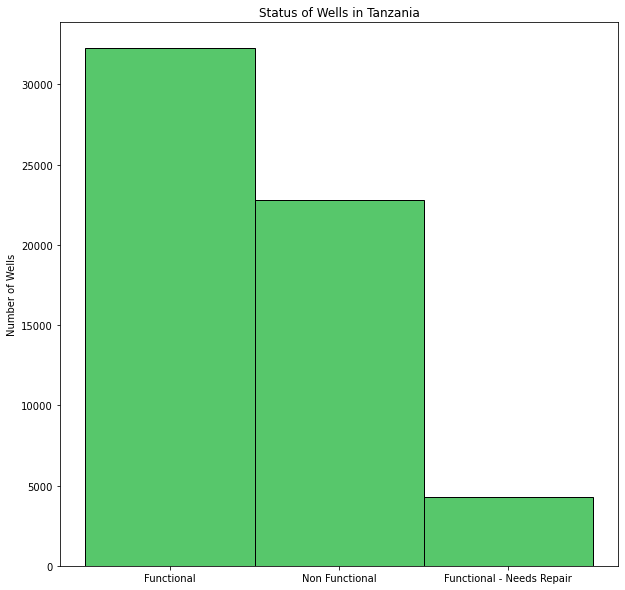

In [114]:
fig, ax = plt.subplots(figsize=(10,10))

sns.histplot(x=df.status_group, color='#1FB53A')


ax.set_title('Status of Wells in Tanzania')
ax.set_ylabel('Number of Wells')
ax.set_xlabel('')
ax.set_xticklabels(['Functional', 'Non Functional', 'Functional - Needs Repair'])

The histplot below shows us how many wells are functional, non-functional, and function but needs repair. The counts are binned based on construction year.

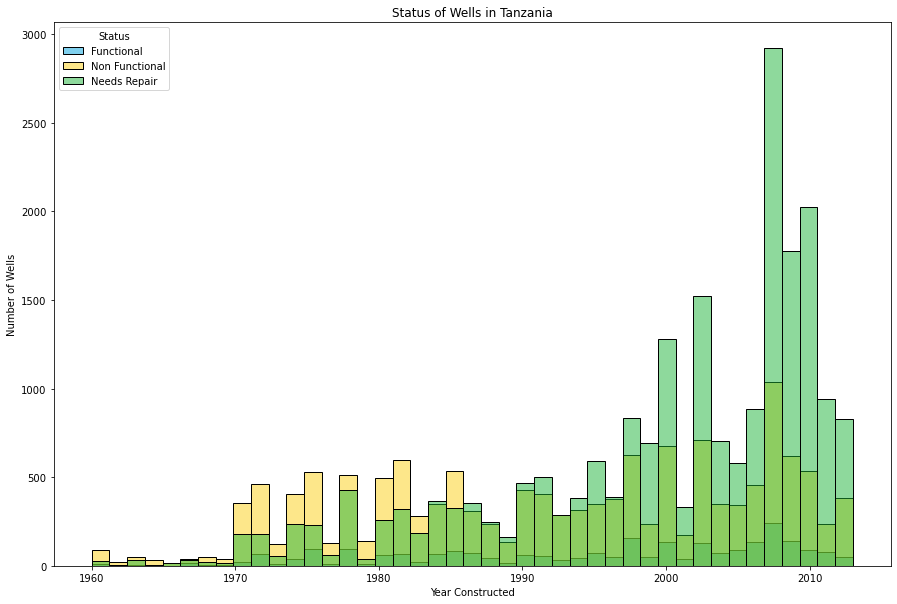

In [109]:
fig, ax = plt.subplots(figsize=(15,10))

sns.histplot(data=df, x='construction_year', hue='status_group', palette=gn_yl_bu_pal)

ax.set_title('Status of Wells in Tanzania')
ax.set_ylabel('Number of Wells')
ax.set_xlabel('Year Constructed')
plt.legend(title='Status', loc='upper left', labels=['Functional', 'Non Functional', 'Needs Repair'])

The chart below shows us the binary breakdown of how many wells fall into each status group. 

<ipython-input-103-6880e9abbfb9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Functional', 'Needs Repair'])


[Text(0, 0, 'Functional'), Text(1, 0, 'Needs Repair')]

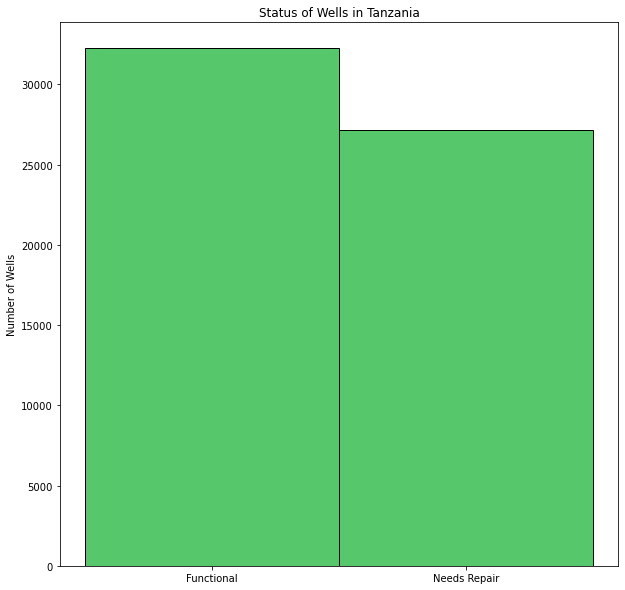

In [103]:
fig, ax = plt.subplots(figsize=(10,10))

sns.histplot(x=y, color='#1FB53A', ax=ax)

ax.set_title('Status of Wells in Tanzania')
ax.set_ylabel('Number of Wells')
ax.set_xlabel('')
ax.set_xticklabels(['Functional', 'Needs Repair'])

The histplot below shows us how many wells are functional and how many need repair. The counts are binned based on construction year.

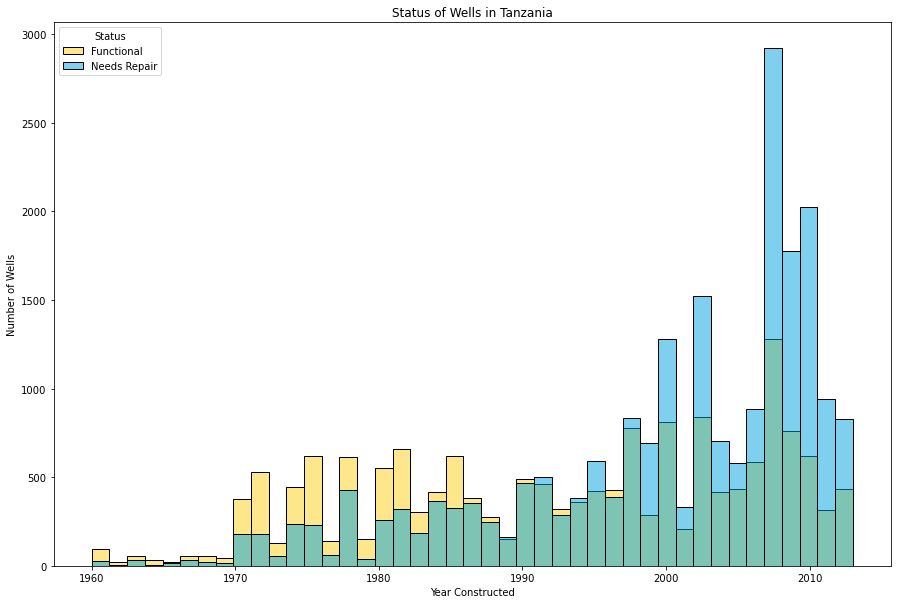

In [105]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.histplot(data=df, x='construction_year', hue='binary_status', palette=bu_yl, ax=ax)

ax.set_title('Status of Wells in Tanzania')
ax.set_ylabel('Number of Wells')
ax.set_xlabel('Year Constructed')
plt.legend(title='Status', loc='upper left', labels=['Functional', 'Needs Repair'])

## Baseline Model
1st Model - "Dummy" Model

In [48]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#label encode y_train & y_test (for later use with XGBoost)
encoder = LabelEncoder()
y_train = pd.Series(encoder.fit_transform(y_train))
y_test = pd.Series(encoder.transform(y_test))

In [95]:
y_train.value_counts()

0    24161
1    20389
dtype: int64

Labels Encoded as: 
- 0 - 'functional'
- 1 - 'needs repair'

In [49]:
X.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,Mundindi,109,True,VWC,False,1999.0,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
8776,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,Natta,280,NaN,Other,True,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
34310,25.0,686,World vision,37.460664,-3.821329,Pangani,Manyara,Ngorika,250,True,VWC,True,2009.0,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple
67743,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,True,VWC,True,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
19728,0.0,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,Nyakasimbi,0,True,NaN,True,NaN,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


We will predict the most frequently occuring value in 'status_group' for each row. 

In [50]:
y.value_counts(normalize=True)

functional      0.543081
needs repair    0.456919
Name: binary_status, dtype: float64

In [51]:
# Create Dummy/Baseline

dummy_model = Pipeline([
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

In [52]:
# Use the class with out dummy pipe

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy',X=X_train, y=y_train)

In [53]:
dummy_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.54233 ± 0.00007 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

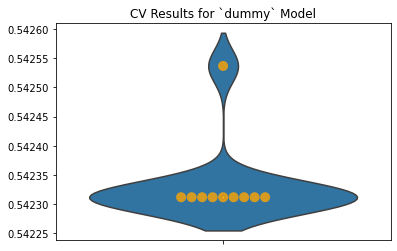

In [54]:
fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

In [55]:
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)

0.5453198653198653

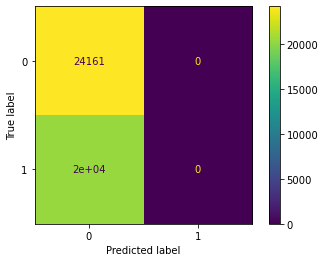

In [56]:
plot_confusion_matrix(dummy_model, X_train, y_train)

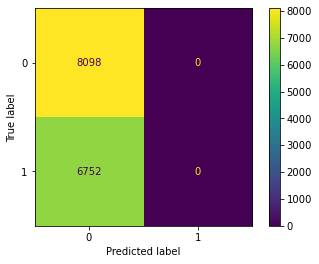

In [74]:
plot_confusion_matrix(dummy_model, X_test, y_test)

## First Simple Model
### Logistic Regression

In [57]:
logreg = LogisticRegression(verbose=2, 
                            random_state=42)

logreg_fsm = Pipeline([
    ('ct', CT),
    ('logreg', logreg)
])

In [58]:
logreg_model_pipe = ModelWithCV(logreg_fsm,
                                model_name='logreg',
                                X=X_train,
                                y=y_train
                               )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP:

In [59]:
logreg_model_pipe.print_cv_summary()

CV Results for `logreg` model:
            0.79059 ± 0.00484 accuracy
        


<AxesSubplot:title={'center':'CV Results for `logreg` Model'}>

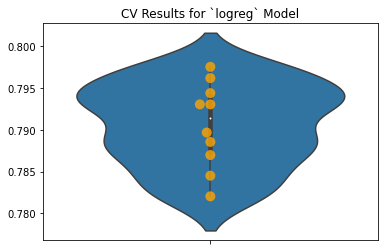

In [60]:
fig, ax = plt.subplots()

logreg_model_pipe.plot_cv(ax=ax)

In [61]:
logreg_fsm.fit(X_train, y_train)
logreg_fsm.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


0.7936026936026936

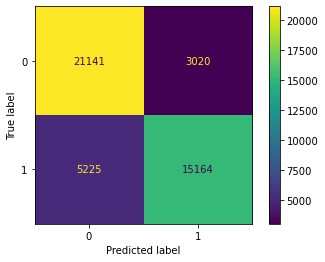

In [72]:
plot_confusion_matrix(logreg_fsm, X_train, y_train)

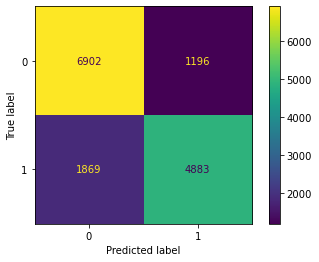

In [73]:
plot_confusion_matrix(logreg_fsm, X_test, y_test)

In [83]:
log_loss(y_test, logreg_fsm.predict_proba(X_test))

0.4387821426476648

### Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_fsm = Pipeline([
    ('ct', CT),
    ('dtc_fsm', dtc)
])

In [ ]:
dtc_model_pipe = ModelWithCV(dtc_fsm, model_name='dtc_fsm', X=X_train, y=y_train)

In [ ]:
dtc_model_pipe.print_cv_summary()

In [ ]:
fig, ax = plt.subplots()

dtc_model_pipe.plot_cv(ax=ax)

In [ ]:
dtc_fsm.fit(X_train, y_train)
dtc_fsm.score(X_test, y_test)

In [ ]:
plot_confusion_matrix(dtc_fsm, X_train, y_train)

In [ ]:
plot_confusion_matrix(dtc_fsm, X_test, y_test)

### Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42)

rfc_fsm = Pipeline([
    ('ct', CT),
    ('rfc_fsm', rfc)
])

In [ ]:
rfc_model_pipe = ModelWithCV(rfc_fsm, model_name='rfc_fsm', X=X_train, y=y_train)

In [ ]:
rfc_model_pipe.print_cv_summary()

In [ ]:
fig, ax = plt.subplots()

rfc_model_pipe.plot_cv(ax=ax)

In [ ]:
rfc_fsm.fit(X_train, y_train)
rfc_fsm.score(X_test, y_test)

In [ ]:
plot_confusion_matrix(rfc_fsm, X_train, y_train)

In [ ]:
plot_confusion_matrix(rfc_fsm, X_test, y_test)

### Gradient Booster

In [ ]:
######################################################################
######################################################################
###################...TAKES A LONG TIME TO RUN...#####################
######################################################################
######################################################################

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

gbc_fsm_pipe = Pipeline([
    ('ct', CT),
    ('gbc_fsm', gbc)
])

In [ ]:
gbc_pipe = ModelWithCV(model=gbc_fsm_pipe,
                       model_name='gbc_pipe',
                       X=X_train,
                       y=y_train)

In [ ]:
gbc_pipe.print_cv_summary()

In [ ]:
fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax)

In [ ]:
gbc_fsm_pipe.fit(X_train, y_train)
gbc_fsm_pipe.score(X_test, y_test)

In [ ]:
plot_confusion_matrix(gbc_fsm_pipe, X_train, y_train)

In [ ]:
plot_confusion_matrix(gbc_fsm_pipe, X_test, y_test)

### XGBoost

In [ ]:
######################################################################
######################################################################
###################...TAKES A LONG TIME TO RUN...#####################
######################################################################
######################################################################

In [ ]:
xgb = XGBClassifier(random_state=42)

xgb_fsm_pipe = Pipeline([
    ('ct', CT),
    ('xgb_fsm', xgb)
])

In [ ]:
xgb_pipe = ModelWithCV(model=xgb_fsm_pipe,
                       model_name='xgb_fsm_pipe',
                       X=X_train,
                       y=y_train)

In [ ]:
xgb_pipe.print_cv_summary()

In [ ]:
fig, ax = plt.subplots()

xgb_pipe.plot_cv(ax=ax)

In [ ]:
xgb_fsm_pipe.fit(X_train, y_train)
xgb_fsm_pipe.score(X_test, y_test)

In [ ]:
plot_confusion_matrix(xgb_fsm_pipe, X_train, y_train)

In [ ]:
plot_confusion_matrix(xgb_fsm_pipe, X_test, y_test)

## Model Choice - Logistic Regression

1. Logistic regression is faster to train than other models
2. Logistic regression is more interpretable which makes it more useful for the non-technical presentation
3. Logistic regression is less prone to overfitting

### GridSearchCV

#### 1st GridSearch

We'll check the following hyperparameters in the first GridSearch
- numeric impute strategy: 'mean', or 'median'
- logistic regression penalty: 'l1', 'l2', or 'elasticnet'
- logistic regression C value: '1e-1', '1.0', '1e2'

In [ ]:
logreg_fsm

In [ ]:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'logreg__penalty':['l1','l2','elasticnet'],
    'logreg__C':[1e-1,1.0,1e2]
         }
first_logreg_gs = GridSearchCV(estimator=logreg_fsm,
                              param_grid=params, cv=10, verbose=2)

In [ ]:
first_logreg_gs.fit(X_train, y_train)

In [ ]:
first_logreg_gs.best_params_

The default hyperparameters are the best options for this model. 

#### 2nd GridSearch

Next, we'll perform a GridSearch to see what the best solver is:
- 'lbfgs'
- 'liblinear'
- 'newton-cg'
- 'newton-cholesky'
- 'sag'
- 'saga'


In [ ]:
params_b = {
    'ct__num_trans__num_impute__strategy':['mean'],
    'logreg__penalty':['l2'],
    'logreg__C':[1.0],
    'logreg__solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga']
         }
second_logreg_gs = GridSearchCV(estimator=logreg_fsm,
                              param_grid=params_b, cv=10, verbose=2)

In [ ]:
second_logreg_gs.fit(X_train, y_train)

In [ ]:
second_logreg_gs.best_params_

The 'liblinear' solver is the best solver for this model. 

## Final Model - Logistic Regression

In [63]:
logreg_final = Pipeline([
    ('ct', CT),
    ('logregfinal', LogisticRegression(penalty='l2', 
                                       C=1.0, 
                                       random_state=42,
                                       max_iter=500,
                                  solver='liblinear'))
])

In [64]:
logreg_final_pipe = ModelWithCV(logreg_final, 
                                model_name='logregfinal', 
                                X=X_train, 
                                y=y_train)

In [65]:
logreg_final_pipe.print_cv_summary()

CV Results for `logregfinal` model:
            0.79118 ± 0.00481 accuracy
        


<AxesSubplot:title={'center':'CV Results for `logregfinal` Model'}>

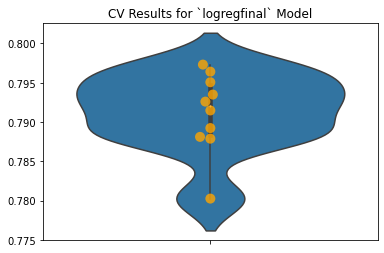

In [66]:
fig, ax = plt.subplots()

logreg_final_pipe.plot_cv(ax=ax)

In [67]:
logreg_final.fit(X_train, y_train)
logreg_final.score(X_test, y_test)

0.7960942760942761

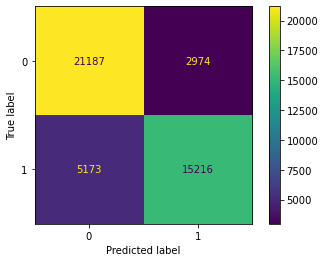

In [71]:
plot_confusion_matrix(logreg_final, X_train, y_train)

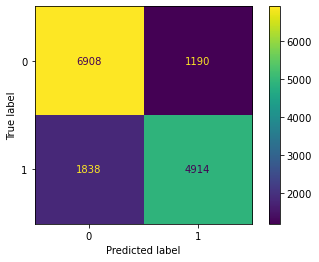

In [68]:
plot_confusion_matrix(logreg_final, X_test, y_test)

### Log Loss

Log loss is a measure of how well the model is able to predict the probability that an example belongs to a certain class. The lower value of log loss for this model indicates that it is better model.

In [82]:
log_loss(y_test, logreg_final.predict_proba(X_test))

0.4358537574446493

In [79]:
y_hat = logreg_final.predict(X_test)

In [70]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.8. 

Our final model's recall on the test set is 0.73 

Our final model's precision on the test set is 0.81 

Our final model's f1-score on the test is 0.76.



### Comparing Models

NameError: name 'rfc_fsm' is not defined

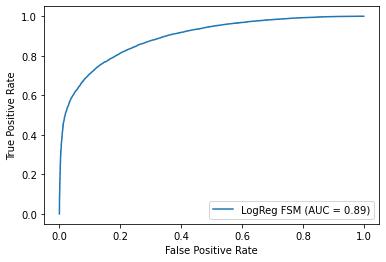

In [93]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_fsm, X_train, y_train, ax=ax, name='LogReg FSM')
plot_roc_curve(rfc_fsm, X_train, y_train, ax=ax, name='RFC FSM')
plot_roc_curve(dtc_fsm, X_train, y_train, ax=ax, name='DTC FSM')
plot_roc_curve(gbc_fsm_pipe, X_train, y_train, ax=ax, name='GBC FSM')
plot_roc_curve(xgb_fsm_pipe, X_train, y_train, ax=ax, name='XGB FSM')
plot_roc_curve(logreg_final, X_train, y_train, ax=ax, name='LogReg Final')



## Further Exploration/Questions

Is there a benefit to knowing specifically which wells need repairs but are functioning as opposed to the wells that are not functioning?

Given more time, I would like to create a model to predict each status group originally given ('functional', 'non functional', and 'functional needs repair') instead of converting the target to a binary outcome.

What are the limiting factors in getting resources to the wells that need repairs?
- Maintenance Professionals?
- Time?
- Money?
- Parts?
- Knowledge?